In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter

from models import Generator, Discriminator
from train import Trainer

In [4]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")
if not os.path.exists(BASE_LOG_DIR):
    os.makedirs(BASE_LOG_DIR)

In [5]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/FullyConvGAN"):
    os.makedirs("imgs/FullyConvGAN")
if not os.path.exists("imgs/CondFullyConvGAN"):
    os.makedirs("imgs/CondFullyConvGAN")

In [6]:
IMG_SIZE = 64

# Downloading and Loading Dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Downsaple to 64x64
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='data/afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/afhq/val', transform=transform)

In [7]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=4
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=4
)

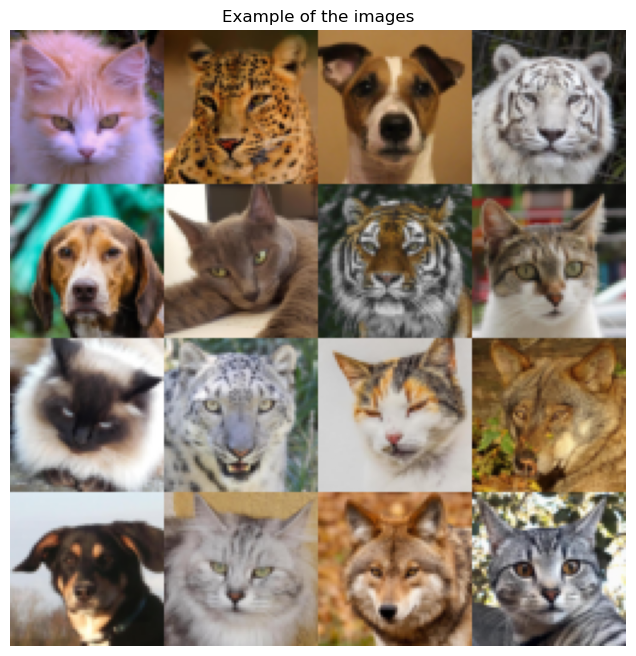

In [8]:
images, labels = next(iter(train_loader))

grid_img = make_grid(images[:16], nrow=4, padding=0, normalize=True)

np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Example of the images")
plt.show()

In [9]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if os.path.exists("imgs/training"):
    shutil.rmtree("imgs/training")
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

In [10]:
generator = Generator(latent_dim=128, num_channels=3, base_channels=32)
generator

Generator(
  (model): Sequential(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))

In [11]:
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=16)
discriminator

Discriminator(
  (model): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
    

In [12]:
latent = torch.randn(16, 128, 1, 1)
fake_img = generator(latent)
score = discriminator(fake_img)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

fake_img.shape = torch.Size([16, 3, 64, 64])
score.shape = torch.Size([16, 1, 1, 1])


In [13]:
CONV_GAN_LOGS = os.path.join(BASE_LOG_DIR, "ConvGAN implementation")
os.makedirs(CONV_GAN_LOGS, exist_ok=True)

shutil.rmtree(CONV_GAN_LOGS)
writer = SummaryWriter(CONV_GAN_LOGS)

In [14]:
trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=128, writer=writer)

In [15]:
trainer.train(data_loader=train_loader)

  0%|          | 0/10000 [00:00<?, ?it/s]

Ep 279 Iter 16175: D_Loss=0.34892, G_Loss=3.86957):   0%|          | 0/10000 [39:04<?, ?it/s] 

KeyboardInterrupt: 

In [16]:
from save_load import save_model

save_model(discriminator, 'discriminator')
save_model(generator, 'generator')

Saved state to checkpoints/checkpoint_discriminator.pth
Saved state to checkpoints/checkpoint_generator.pth


'checkpoints/checkpoint_generator.pth'

In [18]:
from fid import compute_fid

fid = compute_fid(generator, test_loader, device, num_samples=1000)

/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/kellerv1/miniforge3/envs/lab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
print(f"FID = {fid:.2f}")

FID = 230.71-0.00j


We experimented with two different set-up versions.
In the first version, the discriminator had 5 layers, and was trained for 20000 iterations. Frechet Distance was 231.74. We observed huge difference in losses between generator and discriminator, therefore we considered another approach to make them more competable by reducing discriminator's layer size from 5 to 4. After 16175 iterations the new generator produced Frechet Distance equal to <b>230.71</b>, which was a better metric result, however still larger than the best version of VAE (with KLD = 10e-3) which had FID = <b>207.75</b>.

Qualitive analysis showed that VAE produced more realistic images.

We assume that the model would improve its performance with a more complex generator.

tensorboard logs of both versions are provided in the `tboard_logs`, the initial version is marked with v1.